In [1]:
import pandas
import tqdm

## Import Data

The data is downloaded as a gzipped csv file.

.. notes: archives on linux (.zip, .tar.gz, ...)

### Extract

`gunzip winant.csv.gz`

In [2]:
%%bash
gunzip winant.csv.gz

it looks like the resulting file is a csv file. Let's inspect the first few lines:

In [1]:
%%bash
head winant.csv

RePEc:eee:matcom:v:22:y:1980:i:2:p:141-150#1980#A software for evaluating local accuracy in the fourier transform#Vignes,  J. ; Bois,  P.
RePEc:eee:matcom:v:22:y:1980:i:2:p:157-176#1980#Bibliography#Van Remoortere,  P.
RePEc:eee:matcom:v:22:y:1980:i:2:p:98-102#1980#Propagation properties of semi-discretizations of hyperbolic equations#Vichnevetsky,  R.
RePEc:eee:matcom:v:22:y:1980:i:2:p:118-126#1980#The use of low-cost DDA for solving navigational problems#Cennamo,  F.
RePEc:eee:matcom:v:22:y:1980:i:1:p:25-29#1980#Finite element patch approximations and alternating-direction methods#Hayes, Linda J.
RePEc:eee:matcom:v:22:y:1980:i:1:p:61-63#1980#1977#Van Remoortere,  P.
RePEc:eee:matcom:v:22:y:1980:i:1:p:63-78#1980#1978#Van Remoortere,  P.
RePEc:eee:matcom:v:18:y:1976:i:4:p:217-221#1976#Some generalised results on exponential delays#Mohapatra, Pratap K. J., 
RePEc:eee:matcom:v:18:y:1976:i:3:p:171-176#1976#A simulation model for a bottleneck situation on a river#Gelders, Ir. L.,  ; Borsu,

Assumption: each line contains one article with fields:
    - paper
    - date
    - title
    - authors
Article fields are separated by "#".

In [2]:
import pandas
import numpy as np

Our import code requires two fixes:
- some lines have two pounds -> ignore_error_lines
- encoding doesn't seem to be utf-8. Reasonable alternatives
    - ascii
    - ISO-8859-1

In [3]:
# papers = pandas.read_csv("winant.csv", names=["paper", "date", "title", "authors"], dtype={'date':np.int32}, sep="#", error_bad_lines=False, encoding='ISO-8859-1')
papers_ = pandas.read_csv("winant.csv", names=["paper", "date", "title", "authors"], sep="#", error_bad_lines=False, encoding='ISO-8859-1')

In [4]:
pandas.read_csv

<function pandas.io.parsers._make_parser_function.<locals>.parser_f(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)>

In [5]:
dd = papers_['date']

integer columns can't have missing values. (reason lies in float standard)
Two possible remedies:
- keep floats
- remove missing values

In [6]:
# How many articles will we miss ?
"{:.3f}% of all articles don't have a date field".format(dd.isna().sum()/(len(dd)))

"0.004% of all articles don't have a date field"

let's ignore them then.

In [7]:
papers = papers_[~(dd.isna())]
papers['date'] = papers['date'].astype("int")
ind = (papers['date']!=0) & (papers['date']<=2019)
papers = papers.loc[ind,:]

/opt/pablo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
papers.describe()

,date
count,2.871689e+06
mean,2.004050e+03
std,1.438271e+01
min,1.901000e+03
25%,1.999000e+03
50%,2.009000e+03
75%,2.014000e+03
max,2.019000e+03


# Let's look at publication dates

In [9]:
pubdates = papers.groupby('date').count()

In [10]:
from matplotlib import pyplot as plt

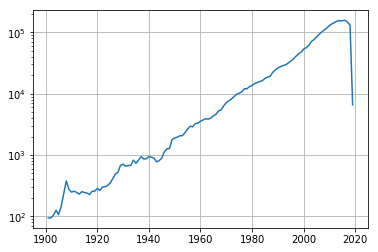

In [11]:
plt.plot(pubdates.index,pubdates['paper'])
plt.yscale('log', basey=10)
plt.grid()

In [12]:
pubdates['date'] = pubdates.index

In [13]:
import statsmodels.api as sm
m = sm.OLS((pubdates['title']), pubdates['date'])
res = m.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  title   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     40.46
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           3.96e-09
Time:                        02:39:48   Log-Likelihood:                -1436.0
No. Observations:                 119   AIC:                             2874.
Df Residuals:                     118   BIC:                             2877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
date          12.5848      1.979      6.361      0.000       8.667      16.503
==============================================================================
Omnibus:                       57.556   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.527
Skew:                           2.071   Prob(JB):                     2.75e-29
Kurtosis:                       6.060   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# We'll improve the db a ittle bit more:
- extract publication information
- hash unique article

hypothesis:
    - publication is denoted by third element of paper

In [14]:
dd = papers['paper']

In [15]:
papers['publication'] = dd.apply(lambda x: x.split(":")[2])

In [16]:
papers['hid'] = papers['paper'].apply(lambda x: hash(x))

In [17]:
papers.head(10)

,paper,date,title,authors,publication,hid
0,RePEc:eee:matcom:v:22:y:1980:i:2:p:141-150,1980,A software for evaluating local accuracy in th...,"Vignes, J. ; Bois, P.",matcom,436013179730247485
1,RePEc:eee:matcom:v:22:y:1980:i:2:p:157-176,1980,Bibliography,"Van Remoortere, P.",matcom,-7793399561440329986
2,RePEc:eee:matcom:v:22:y:1980:i:2:p:98-102,1980,Propagation properties of semi-discretizations...,"Vichnevetsky, R.",matcom,-5270251140403222114
3,RePEc:eee:matcom:v:22:y:1980:i:2:p:118-126,1980,The use of low-cost DDA for solving navigation...,"Cennamo, F.",matcom,-8348673435217679674
4,RePEc:eee:matcom:v:22:y:1980:i:1:p:25-29,1980,Finite element patch approximations and altern...,"Hayes, Linda J.",matcom,4359801616303864773
5,RePEc:eee:matcom:v:22:y:1980:i:1:p:61-63,1980,1977,"Van Remoortere, P.",matcom,448604689793963040
6,RePEc:eee:matcom:v:22:y:1980:i:1:p:63-78,1980,1978,"Van Remoortere, P.",matcom,5025985671111443290
7,RePEc:eee:matcom:v:18:y:1976:i:4:p:217-221,1976,Some generalised results on exponential delays,"Mohapatra, Pratap K. J.,",matcom,4976500017707850777
8,RePEc:eee:matcom:v:18:y:1976:i:3:p:171-176,1976,A simulation model for a bottleneck situation ...,"Gelders, Ir. L., ; Borsu, Mme A.",matcom,3309100646830585799
9,RePEc:eee:matcom:v:18:y:1976:i:3:p:165-170,1976,Simulation of queueing network with time varyi...,"Fan, Walter",matcom,-5045364908789053777


In [18]:
papers.to_csv("papers.csv")

Other ideas:
- split authors
- remove dummy titles
- llok for publication correspondances

## Now look at citation file

In [53]:
import tqdm

In [54]:
%%bash
gunzip iscited.txt.gz

gzip: iscited.txt.gz: No such file or directory


CalledProcessError: Command 'b'gunzip iscited.txt.gz\n'' returned non-zero exit status 1.

In [191]:
%%bash
head iscited.txt

REPEC:kap:jinten:v:5:y:2007:i:3:p:85-110 RePEc:nmp:nuland:2548
REPEc:aea:aecrev:v:86:y:1996:i:3:p:374-87 RePEc:zbw:glodps:204
RePEC:nbr:nberwo:6694 RePEc:wpa:wuwpma:0303018
RePEC:nbr:nberwo:7864 RePEc:wpa:wuwpma:0303018
RePEC:nbr:nberwo:8230 RePEc:ucb:calbcd:c01-120#RePEc:wpa:wuwpma:0303018
RePEc:aah:aarhec:2000-1 RePEc:cep:sercdp:0025#RePEc:ipt:iptwpa:jrc50011#RePEc:oup:cesifo:v:60:y:2014:i:1:p:246-256.#RePEc:pra:mprapa:69872#RePEc:pra:mprapa:69874#RePEc:feu:wfewop:y:2013:m:7:d:0:i:22#RePEc:fip:fedawp:99-15#RePEc:aah:aarhec:2000-7#RePEc:aah:aarhec:2000-14#RePEc:aah:aarhec:2000-16#RePEc:pra:mprapa:9939#RePEc:taf:japsta:v:30:y:2003:i:6:p:635-667#RePEc:upf:upfgen:1439
RePEc:aah:aarhec:2000-11 RePEc:iza:izadps:dp341
RePEc:aah:aarhec:2000-12 RePEc:eee:matsoc:v:44:y:2002:i:1:p:91-113#RePEc:eee:matsoc:v:45:y:2003:i:2:p:185-203
RePEc:aah:aarhec:2000-16 RePEc:aah:aarhec:2001-2
RePEc:aah:aarhec:2000-17 RePEc:ums:papers:2015-13#RePEc:ums:papers:2006-04#RePEc:ums:papers:2011-26#RePEc:ums:papers:2

In [192]:
with open("iscited.txt") as f:
    lcites = f.readlines()

In [193]:
lcites = [l.strip() for l in lcites]

In [194]:
llc = [lu.split(" ") for lu in lcites]

In [195]:
llc = [(lu[0], lu[1].split("#")) for lu in llc]

In [196]:
ncites = [len(e[1]) for e in llc]
ncites = [e for e in ncites if e>=100]

In [197]:
import seaborn

/opt/pablo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


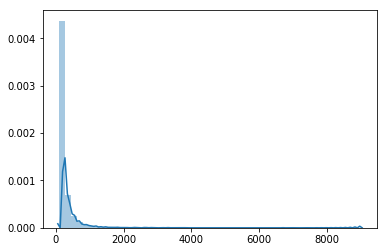

In [198]:
seaborn.distplot(ncites)

In [199]:
# we remove articles cited by less than 100 articles

In [200]:
llc = [e for e in llc if len(e[1])>=500]

In [201]:
len(llc)

1654

In [233]:
llh = llc

In [234]:
#llh = [(hash(e[0]), [hash(k) for k in e[1]]) for e in llc]

In [235]:
llh.sort(key=lambda x: x[0])

In [236]:
publis = [l[0] for l in llh]

In [237]:
publis[:5]

['RePEc:aea:aecrev:v:100:y:2010:i:2:p:573-78',
 'RePEc:aea:aecrev:v:100:y:2010:i:3:p:763-801',
 'RePEc:aea:aecrev:v:102:y:2012:i:2:p:1029-61',
 'RePEc:aea:aecrev:v:103:y:2013:i:6:p:2121-68',
 'RePEc:aea:aecrev:v:59:y:1969:i:2:p:251-60']

In [265]:
test = []
for l in tqdm.tqdm_notebook(llh):
    dest = l[0]
    tt = []
    for source in l[1]:
        # naive filter
        if source in publis:
            tt.append(source)
    test.append(tt)
        

In [267]:
#test

In [268]:
edgelist = []
for l in tqdm.tqdm_notebook(llh):
    dest = l[0]
    for source in l[1]:
        # naive filter
        if source in publis:
            edgelist.append((dest,source))
        

In [269]:
G = nx.from_edgelist(edgelist)

In [275]:
import pygraphviz as pgv

In [272]:
nx.write_gml(G,"graph.gml")

In [239]:
import networkx

In [240]:
rhs = [e[1] for e in edgelist]

In [241]:
lhs = np.array([e[0] for e in edgelist])

In [242]:
pos = np.searchsorted(lhs, rhs)

In [243]:
pos = np.minimum(pos,len(lhs)-1)

In [244]:
exist = (lhs[pos] == rhs)

In [245]:
# we could remove any article cited by an article which is not in the database
print("There are still {} articles.".format(len(exist)))

There are still 3036 articles.


In [246]:
# ... which is still too much, what if we remove articles that are cited by less than 100 articles ?

In [247]:
edges = np.array(edgelist)

In [248]:
normed_edges = np.zeros((len(lhs),3))

In [249]:
normed_edges[:,0] = range(len(lhs))

In [250]:
normed_edges[:,1] = pos

In [251]:
exist = lhs[pos]==rhs

In [252]:
cured_edges =  normed_edges[exist,:]

In [253]:
cured_edges[:,2] = 1

In [254]:
import scipy.sparse

In [255]:
cured_edges.shape

(1808, 3)

In [256]:
mat = scipy.sparse.coo_matrix((cured_edges[:,0],(cured_edges[:,1],cured_edges[:,2])),shape=(len(exist),len(exist)))

In [257]:
scipy.sparse.save_npz("adacency_matrix.npz", mat)

In [258]:
import networkx as nx

In [259]:
G = nx.from_scipy_sparse_matrix(mat)

In [260]:
nx.write_gexf(G, "graph.gephi")

In [261]:
nx.write_gml(G,"graph.gml")

In [262]:
print( nx.info(G) )

Name: 
Type: Graph
Number of nodes: 3036
Number of edges: 261
Average degree:   0.1719


In [263]:
degs = []
for n in G.nodes:
    degs.append(G.degree(n))
    

In [264]:
degs

[0,
 261,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1

In [92]:
import graphistry

In [93]:
# graphistry.bind(source='src', destination='dst', node='nodeid').plot(G)

ValueError: API key not set explicitly in `register()` or available at GRAPHISTRY_API_KEY

In [38]:
# papids = list(papers['hid'])
# cleaned = []
# for lh in tqdm.tqdm_notebook(llh):
#     iid = lh[0]
#     try:
#         cleaned.append(papids.index(iid))
#     except:
#         pass

In [39]:
spapers = papers.sort_values('hid')

In [40]:
a = np.array( spapers['hid'] )

In [41]:
b = np.array( [e[0] for e in llh])

In [42]:
c = np.searchsorted(a,b)

In [43]:
F = (a[c]==b)
iF = np.where(F)[0]

In [44]:
lhs = spapers.iloc[c,:]

In [45]:
rhs = [llh[x] for x in iF]

In [46]:
nodes = [e[0] for e in rhs]

In [47]:
# cited = sum([r[1] for r in rhs], [])

In [48]:
total_citations = sum(len(e[1]) for e in rhs) # total numbe of citations

In [49]:
citation_sizes = [len(e[1]) for e in rhs]

In [50]:
all_citations = np.zeros(total_citations, dtype=np.int64)

In [51]:
pbs = []
n = 0
for nn, nnn in rhs:
    for i in nnn:
        try:
            all_citations[n] = i
        except:
            pbs.append(i)
#             print(i)
        n+=1

In [52]:
all_citations

array([ 7886554926748046995,  8414319289065573149,  2454094017063134942,
       ..., -8141759526952285082, -4061623176061796639,
       -6322079519724073215])

In [53]:
lhs = lhs.sort_values("hid")

In [54]:
x = lhs['hid']

In [55]:
inds = np.searchsorted(x, all_citations)

In [56]:
len(inds)

14131872

In [57]:
len(all_citations)

14131872

In [58]:
x.loc[inds[:5]]

/opt/pablo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


1049310    7.032716e+18
1081565             NaN
716182              NaN
89865               NaN
914638              NaN
Name: hid, dtype: float64

In [59]:
cite_exist = (x.loc[inds] == all_citations)

/opt/pablo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


ValueError: Lengths must match to compare

In [95]:
# new_graph = []
# for i, nn in tqdm.tqdm_notebook(enumerate(rhs)):
#     nnn = []
#     for dest in nn[1]:
#         if nnn in nodes:
#             nnn.append(dest)
#     new_graph.append(nnn)

In [96]:
len(new_graph)

NameError: name 'new_graph' is not defined

In [97]:
papers_clean = papers.iloc[c[ifound],:]

NameError: name 'ifound' is not defined

In [192]:
max( [len(e) for e in new_graph] )

0